In [3]:
import pandas as pd
import re
from itertools import chain
from src.utils import neutralise_charges, postsanitize_smiles
from typing import List
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

In [2]:
rhea_directions = pd.read_csv('/home/stef/bottle/data/mapping/rhea-directions.tsv', '\t')
rhea_smarts = pd.read_csv('/home/stef/bottle/data/mapping/rhea-reaction-smiles.tsv', '\t', header=None)
rhea_smarts.columns = ["rhea_id", "smarts"]
rhea_smarts.set_index('rhea_id', inplace=True)

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Rhea IDs w smarts are a subset of all ids in rhea-directions

rhea_all = set()
for col in rhea_directions.columns:
    rhea_all = rhea_all | set(rhea_directions.loc[:, col])
w_smarts = set(rhea_smarts.index.values)
w_smarts - rhea_all

set()

In [4]:
# Only rhea IDs in LR / RL have a smarts entry, and if there is one there are both!

codes = []
counts = []
for i, row in rhea_directions.iterrows():
    ct = 0
    code = ''
    for id in row:
        if id in w_smarts:
            ct += 1
            code += '1'
        else:
            code += '0'
    counts.append(ct)
    codes.append(code)

print(set(counts))
print(rhea_directions.columns)
print(set(codes))

{0, 2}
Index(['RHEA_ID_MASTER', 'RHEA_ID_LR', 'RHEA_ID_RL', 'RHEA_ID_BI'], dtype='object')
{'0110', '0000'}


In [5]:
# Create look up of (LR, RL) rhea ids from not LR, RL

lookup_directed_ids = {}

for i, row in rhea_directions.iterrows():
    lookup_directed_ids[row['RHEA_ID_MASTER']] = (row['RHEA_ID_LR'], row['RHEA_ID_RL'])
    lookup_directed_ids[row['RHEA_ID_BI']] = (row['RHEA_ID_LR'], row['RHEA_ID_RL'])

In [6]:
rhea_uniprot = pd.read_csv('/home/stef/bottle/data/mapping/rhea2uniprot_sprot.tsv', sep='\t')
up_pull = pd.read_csv('/home/stef/bottle/data/mapping/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv', sep='\t')
up_pull.set_index("Entry", inplace=True)

In [7]:
# Get rhea ids for up entries

rhea_up_pairs= set()
pattern = r'RHEA:(\d{1,6})' # Regular expression pattern
no_matches = []

for entry, row in up_pull.iterrows():
    cat_act = row["Catalytic activity"]
    if pd.isna(cat_act):
        no_matches.append(entry)
    else:
        matches = re.findall(pattern, cat_act)

        for match in matches:
            rhea_up_pairs.add((int(match), entry))

        if len(matches) == 0:
            no_matches.append(entry)

In [8]:
# Pull rhea-up pairs from rhea's tsv

rhea_up_pairs_alt = set()
for i, row in rhea_uniprot.iterrows():
    rhea_up_pairs_alt.add((row['RHEA_ID'], row['ID']))

In [9]:
len(rhea_up_pairs_alt ^ rhea_up_pairs) / len(rhea_up_pairs_alt | rhea_up_pairs)

0.006352646521386967

In [10]:
# Filter by smarts avail

def filter_pairs_by_smarts(pair):
    r = pair[0]
    if r in lookup_directed_ids:
        if lookup_directed_ids[r][0] in w_smarts or lookup_directed_ids[r][1] in w_smarts:
            return True
        else:
            return False
    else:
        return False

rhea_up_pairs_w_smarts = set(filter(filter_pairs_by_smarts, list(rhea_up_pairs)))
rhea_up_pairs_alt_w_smarts = set(filter(filter_pairs_by_smarts, list(rhea_up_pairs_alt)))

In [11]:
# After filtering by avail of smarts, the difference in rhea-upid pairs
# gotten by the two methods is small

len(rhea_up_pairs_w_smarts ^ rhea_up_pairs_alt_w_smarts) / len(rhea_up_pairs_alt_w_smarts | rhea_up_pairs_w_smarts)

0.004448221554483126

# Compare molecular standardization

In [12]:
smiles = set()
for i,row in rhea_smarts.iterrows():
    this_smiles = list(chain(*[elt.split('.') for elt in row['smarts'].split('>>')]))
    for smi in this_smiles:
        smiles.add(smi)

smiles = list(smiles)

In [20]:
def old_sanitize(smiles:List[str]):
    smiles = postsanitize_smiles(smiles)[0]
    neutral_mols = [neutralise_charges(Chem.MolFromSmiles(smi, sanitize=False)) for smi in smiles] 
    return [Chem.MolToSmiles(mol) for mol in neutral_mols]
    

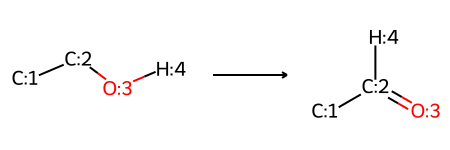

In [30]:
from IPython.display import SVG # to use Scalar Vector Graphics (SVG) not bitmaps, for cleaner lines

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw # to draw molecules
from rdkit.Chem.Draw import IPythonConsole # to draw inline in iPython
from rdkit.Chem import rdDepictor  # to generate 2D depictions of molecules
from rdkit.Chem.Draw import rdMolDraw2D # to draw 2D molecules using vectors
from rdkit.Chem.MolStandardize import rdMolStandardize

AllChem.ReactionFromSmarts('[C:1]-[C:2](-[O:3]-[H:4])>>[C:1]-[C:2](=[O:3])(-[H:4])')

In [38]:
def standardize_mol(mol, remove_stereo=False):
    """Standardize the RDKit molecule, select its parent molecule, uncharge it, 
    then enumerate all the tautomers.
    If verbose is true, an explanation of the steps and structures of the molecule
    as it is standardized will be output."""
    # Follows the steps from:
    #  https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg Landrum) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ -- thanks JP!
    
    
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 

    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # Note: no attempt is made at reionization at this step
    # nor ionization at some pH (RDKit has no pKa caculator);
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogues, etc.
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    assert taut_uncharged_parent_clean_mol != None
    
    
    if remove_stereo:
        Chem.rdmolops.RemoveStereochemistry(taut_uncharged_parent_clean_mol)

    return taut_uncharged_parent_clean_mol


def standardize_smiles(smiles, remove_stereo=False):
  """Standardize the SMILES string, select its parent molecule, uncharge it, 
    then enumerate all the tautomers."""
  std_mol = standardize_mol(Chem.MolFromSmiles(smiles), remove_stereo)
  return Chem.MolToSmiles(std_mol)


In [39]:
def sanitize_smiles(smiles:List[str], remove_stereo=False):
    san_smiles = []
    for smi in smiles:
        san_smiles.append(standardize_smiles(smi, remove_stereo))
    return san_smiles


In [40]:
n = 10
san_smiles = old_sanitize(smiles[:n])
san_smiles_alt = sanitize_smiles(smiles[:n], remove_stereo=True)

[12:18:58] Initializing MetalDisconnector
[12:18:58] Running MetalDisconnector
[12:18:58] Initializing Normalizer
[12:18:58] Running Normalizer
[12:18:58] Initializing MetalDisconnector
[12:18:58] Running MetalDisconnector
[12:18:58] Initializing Normalizer
[12:18:58] Running Normalizer
[12:18:58] Running LargestFragmentChooser
[12:18:58] Fragment: *P(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OC(=O)[C@@H]1CCC[NH2+]1
[12:18:58] New largest fragment: *P(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OC(=O)[C@@H]1CCC[NH2+]1 (50)
[12:18:58] Running Uncharger
[12:18:58] Removed negative charge.
[12:18:58] Removed positive charge.
[12:18:58] Initializing MetalDisconnector
[12:18:58] Running MetalDisconnector
[12:18:58] Initializing Normalizer
[12:18:58] Running Normalizer
[12:18:58] Initializing MetalDisconnector
[12:18:58] Running MetalDisconnector
[12:18:58] Initializing Normalizer
[12:18:58] Running Normalizer
[12:18:58] Running LargestFragmentChooser
[12:18:58] F

In [41]:
for smi, san, san_alt in zip(smiles, san_smiles, san_smiles_alt):
    print(san, san_alt)

*P(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OC(=O)C1CCCN1 *P(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OC(=O)C1CCCN1
CCCCCCCCC=CCCCCCCCC=CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O CCCCCCCCC=CCCCCCCCC=CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O
O=C(Cc1ccc(OS(=O)(=O)O)cc1)Nc1ncc(-c2ccc(OS(=O)(=O)O)cc2)nc1Cc1ccccc1 O=C(Cc1ccc(OS(=O)(=O)O)cc1)Nc1ncc(-c2ccc(OS(=O)(=O)O)cc2)nc1Cc1ccccc1
O=C(O)C(=O)Cc1cccc(O)c1 O=C(O)C(=O)Cc1cccc(O)c1
O=C(O)CC(=C[PH](=O)O)C(=O)O O=C(O)CC(=C[PH](=O)O)C(=O)O
O=CC=CC=C(O)C(=O)O O=CC=CCC(=O)C(=O)O
CC(C)(O)C=O CC(C)(O)C=O
O=C(O)C(O)C(O)C(O)C(O)CO O=C(O)C(O)C(O)C(O)C(O)CO
NC(=O)CCCCC(S)CCS NC(=O)CCCCC(S)CCS
*C1=Nc2c(ncn2C2OC(CO)C(O)C2O)C(=*)N1 *C1=NC(=*)c2ncn(C3OC(CO)C(O)C3O)c2N1


In [27]:
len(smiles)

12272